In [263]:
%matplotlib widget

import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord

## Useful constants

In [264]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

G = 6.67430e-11 # N m^2 kg^-2

## Lambert solver from Vallado

In [265]:
def mag(vec):
    return np.linalg.norm(vec)

def findc2c3(znew):
    small = 1e-8
    if znew > small:
        sqrtz = np.sqrt(znew)
        c2 = (1.0 - np.cos(sqrtz)) / znew
        c3 = (sqrtz - np.sin(sqrtz)) / (sqrtz**3)
    elif znew < -small:
        sqrtz = np.sqrt(-znew)
        c2 = (1.0 - np.cosh(sqrtz)) / znew
        c3 = (np.sinh(sqrtz) - sqrtz) / (sqrtz**3)
    else:
        c2 = 0.5
        c3 = 1.0 / 6.0
    return c2, c3


# ------------------------------------------------------------------------------
#
#                           function lambertu
#
#  this function solves the lambert problem for orbit determination and returns
#    the velocity vectors at each of two given position vectors.  the solution
#    uses universal variables for calculation and a bissection technique
#    updating psi.
#
#  author        : david vallado                  719-573-2600    1 mar 2001
#
#  inputs          description                    range / units
# Following line added by Barrows 1/2014
#    mu          - central body gravitational parameter  km^3/sec^2
#    r1          - ijk position vector 1          km
#    r2          - ijk position vector 2          km
#    dm          - direction of motion            'l','s'
#    dtsec       - time between r1 and r2         s
#    nrev        - multiple revoluions            0, 1, ...
#
#  outputs       :
#    v1          - ijk velocity vector            km / s
#    v2          - ijk velocity vector            km / s
#    error       - error flag                     'ok', ...
#
#  locals        :
#    vara        - variable of the iteration,
#                  not the semi-axis
#    y           - area between position vectors
#    upper       - upper bound for z
#    lower       - lower bound for z
#    cosdeltanu  - cosine of true anomaly change  rad
#    f           - f expression
#    g           - g expression
#    gdot        - g dot expression
#    xold        - old universal variable x
#    xoldcubed   - xold cubed
#    zold        - old value of z
#    znew        - new value of z
#    c2new       - c2(z) function
#    c3new       - c3(z) function
#    timenew     - new time                       s
#    small       - tolerance for roundoff errors
#    i, j        - index
#
#  coupling      :
#    mag         - magnitude of a vector
#    dot         - dot product of two vectors
#    findc2c3    - find c2 and c3 functions
#
#  references    :
#    vallado       2001, 459-464, alg 55, ex 7-5
#
# [vo,v,errorl] = lambertu ( ro,r, dm, nrev, dtsec );
# ------------------------------------------------------------------------------



def lambert_vallado_universal(mu, r1, r2, dm, nrev, dtsec):
    small = 1e-5
    twopi = 2.0 * np.pi
    numiter = 500
    errorl = "ok"

    ro = r1
    r = r2
    magro = mag(ro)
    magr = mag(r)
    vo = np.zeros(3)
    v = np.zeros(3)

    cosdeltanu = nrev + np.dot(ro, r) / (magro * magr)
    vara = -np.sqrt(magro * magr * (1.0 + cosdeltanu)) if dm == 'l' else np.sqrt(magro * magr * (1.0 + cosdeltanu))

    if abs(vara) <= small:
        return vo, v, "impos180"

    # Initial guesses
    psiold = 0.0
    c2new = 0.5
    c3new = 1.0 / 6.0

    # Bounds for psi
    if nrev == 0:
        upper = 4.0 * np.pi ** 2
        lower = -4.0 * twopi * np.pi
    elif nrev == 1:
        upper = 16.0 * np.pi ** 2
        lower = 4.0 * np.pi ** 2
    else:
        upper = 36.0 * np.pi ** 2
        lower = 16.0 * np.pi ** 2

    loops = 0
    ynegktr = 1
    dtnew = -10.0

    while abs(dtnew - dtsec) >= small and loops < numiter and ynegktr <= 10:
        if abs(c2new) > small:
            y = magro + magr - (vara * (1.0 - psiold * c3new) / np.sqrt(c2new))
        else:
            y = magro + magr

        if vara > 0.0 and y < 0.0:
            while y < 0.0 and ynegktr < 10:
                psinew = 0.8 * (1.0 / c3new) * (1.0 - (magro + magr) * np.sqrt(c2new) / vara)
                c2new, c3new = findc2c3(psinew)
                psiold = psinew
                lower = psiold
                if abs(c2new) > small:
                    y = magro + magr - (vara * (1.0 - psiold * c3new) / np.sqrt(c2new))
                else:
                    y = magro + magr
                ynegktr += 1

        if ynegktr < 10:
            xold = np.sqrt(y / c2new) if abs(c2new) > small else 0.0
            xoldcubed = xold ** 3
            dtnew = (xoldcubed * c3new + vara * np.sqrt(y)) / np.sqrt(mu)

            if dtnew < dtsec:
                lower = psiold
            if dtnew > dtsec:
                upper = psiold

            psinew = 0.5 * (upper + lower)
            c2new, c3new = findc2c3(psinew)
            psiold = psinew
            loops += 1

            if abs(dtnew - dtsec) < small and loops == 1:
                dtnew = dtsec - 1.0

    if loops >= numiter or ynegktr >= 10:
        errorl = "gnotconv" if ynegktr < 10 else "y negati"
    else:
        f = 1.0 - y / magro
        gdot = 1.0 - y / magr
        g = 1.0 / (vara * np.sqrt(y / mu))

        vo = (r - f * ro) * g
        v = (gdot * r - ro) * g

    return vo, v, errorl

## Lambert from Curtis

In [266]:
def stumpS(z):
    """
    Stumpff function S(z), Eq. 3.52
    """
    if z > 0:
        return (np.sqrt(z) - np.sin(np.sqrt(z))) / z**1.5
    elif z < 0:
        return (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (-z)**1.5
    else:
        return 1.0/6.0

def stumpC(z):
    """
    Stumpff function C(z), Eq. 3.53
    """
    if z > 0:
        return (1 - np.cos(np.sqrt(z))) / z
    elif z < 0:
        return (np.cosh(np.sqrt(-z)) - 1) / (-z)
    else:
        return 0.5

# ------------------------------------------------------------------------------
#
# This function solves Lambert's problem.
# 
#   mu         - gravitational parameter (km^3/s^2)
#   R1, R2     - initial and final position vectors (km)
#   r1, r2     - magnitudes of R1 and R2
#   t          - the time of flight from R1 to R2 (a constant) (s)
#   V1, V2     - initial and final velocity vectors (km/s)
#   c12        - cross product of R1 into R2
#   theta      - angle between R1 and R2
#   string     - 'pro'   if the orbit is prograde
#                'retro' if the orbit is retrograde
#   A          - a constant given by Equation 5.35
#   z          - alpha*x^2, where alpha is the reciprocal of the
#                semimajor axis and x is the universal anomaly
#   y(z)       - a function of z given by Equation 5.38
#   F(z,t)     - a function of the variable z and constant t,
#              - given by Equation 5.40
#   dFdz(z)    - the derivative of F(z,t), given by Equation 5.43
#   ratio      - F/dFdz
#   tol        - tolerance on precision of convergence
#   nmax       - maximum number of iterations of Newton's procedure
#   f, g       - Lagrange coefficients
#   gdot       - time derivative of g
#   C(z), S(z) - Stumpff functions
#   dum        - a dummy variable
#   dm should be 'pro' (prograde) or 'retro' (retrograde)
#   nrev is ignored (no multi-revolution solutions)
#
# ------------------------------------------------------------------------------

def AA279lambert_curtis(mu, R1, R2, dm='pro', nrev=0, dtsec=0.0):
    # --- Setup and geometry
    R1 = np.asarray(R1, float)
    R2 = np.asarray(R2, float)
    t  = dtsec
    
    r1 = np.linalg.norm(R1)
    r2 = np.linalg.norm(R2)
    
    c12 = np.cross(R1, R2)
    theta = np.arccos(np.dot(R1, R2) / (r1 * r2))
    
    if dm not in ('pro', 'retro'):
        print("** Prograde trajectory assumed.")
        dm = 'pro'
    if dm == 'pro':
        if c12[2] <= 0:
            theta = 2*np.pi - theta
    else:
        if c12[2] >= 0:
            theta = 2*np.pi - theta
    
    # Constant A, Eq. 5.35
    A = np.sin(theta) * np.sqrt(r1 * r2 / (1 - np.cos(theta)))
    
    # Nested y(z)
    def y(z):
        Cz = stumpC(z)
        Sz = stumpS(z)
        return r1 + r2 + A*(z*Sz - 1)/np.sqrt(Cz)
    
    # Safeguarded F(z)
    def F(z):
        Cz = stumpC(z)
        Sz = stumpS(z)
        yz = y(z)
        if yz <= 0 or Cz <= 0:
            return np.nan
        return (yz/Cz)**1.5 * Sz + A*np.sqrt(yz) - np.sqrt(mu)*t
    
    # Safeguarded derivative dF/dz
    def dFdz(z):
        Cz = stumpC(z)
        Sz = stumpS(z)
        yz = y(z)
        if yz <= 0 or Cz <= 0:
            return np.nan
        # special-case near z=0
        if abs(z) < 1e-8:
            return (np.sqrt(2)/40)*yz**1.5 + A/8*(np.sqrt(yz) + A*np.sqrt(1/(2*yz)))
        # general form
        term1 = (yz/Cz)**1.5 * (
            0.5/z*(Cz - 3*Sz/(2*Cz))
            + 3*Sz**2/(4*Cz)
        )
        term2 = A/8 * (3*Sz/Cz*np.sqrt(yz) + A*np.sqrt(Cz/yz))
        return term1 + term2
    
    # --- Bracket-search for F(z)>=0
    z = -100.0
    max_z = 1e6
    while True:
        fz = F(z)
        if np.isfinite(fz) and fz >= 0:
            break
        z += 0.1
        if z > max_z:
            raise RuntimeError("Failed to bracket root for F(z).")
    
    # --- Newton iteration
    tol  = 1e-8
    nmax = 5000
    for i in range(nmax):
        fz = F(z)
        df = dFdz(z)
        ratio = fz / df
        if not np.isfinite(ratio):
            raise RuntimeError(f"Newton diverged at iter {i}, z={z}")
        z -= ratio
        if abs(ratio) < tol:
            break
    else:
        raise RuntimeError(f"Lambert solver failed to converge in {nmax} iters.")
    
    # --- Lagrange coefficients & velocities
    yz = y(z)
    f   = 1 - yz/r1
    g   = A * np.sqrt(yz/mu)
    gdot = 1 - yz/r2
    
    v1 = (R2 - f*R1) / g
    v2 = (gdot*R2 - R1) / g
    
    return v1, v2, 'finished'

In [267]:
## Define initial and final orbits

In [268]:
# Useful constants
mu = 1.32712440018e20 # m^3 sec^-2
AU = 150000000000.0

# orbit radii
a1 = 1   * AU
a2 = 1.5 * AU

# mean motions
n1 = np.sqrt(mu / a1 ** 3)
n2 = np.sqrt(mu / a2 ** 3)

# initial phases
L0_1 = 0.0
L0_2 = 0.2

# min and max transfer times
min_transfer = 100.0 * 86400.0
max_transfer = 600.0 * 86400.0

# time resolution
npts = 150

t = np.linspace(0, 86400.0 * 365 * 4, npts)

t_dep, t_arr = np.meshgrid(t,t)
t_arr        = t_arr + min_transfer
tof          = t_arr - t_dep
dv_total     = np.zeros(t_dep.shape)
dv_total[:]  = np.nan

# positions of planets
x1 = a1 * np.cos(n1 * t + L0_1)
y1 = a1 * np.sin(n1 * t + L0_1)

x2 = a2 * np.cos(n2 * t + L0_2)
y2 = a2 * np.sin(n2 * t + L0_2)

# velocities of planets
v1 = np.sqrt(mu / a1)
v2 = np.sqrt(mu / a2)

vx1 = - v1 * np.sin(n1 * t + L0_1)
vy1 =   v1 * np.cos(n1 * t + L0_1)

vx2 = - v2 * np.sin(n2 * t + L0_2)
vy2 =   v2 * np.cos(n2 * t + L0_2)

# rotate second (Mars) orbit
alpha = 0.0 * deg2rad

x2_rot = x2
y2_rot = y2
z2_rot = y2 * 0.0

vx2_rot = vx2
vy2_rot = vy2
vz2_rot = vy2 * 0.0

for i in range(npts):
    rotation_matrix = coord.rotation(alpha, 1)
    R2_rot = rotation_matrix @ np.array([x2_rot[i], y2_rot[i], z2_rot[i]])
    x2_rot[i] = R2_rot[0]
    y2_rot[i] = R2_rot[1]
    z2_rot[i] = R2_rot[2]

    V2_rot = rotation_matrix @ np.array([vx2_rot[i], vy2_rot[i], vz2_rot[i]])
    vx2_rot[i] = V2_rot[0]
    vy2_rot[i] = V2_rot[1]
    vz2_rot[i] = V2_rot[2]

In [269]:
#### As a check, plot orbital positions and velocities

Text(0, 0.5, 'Y [m]')

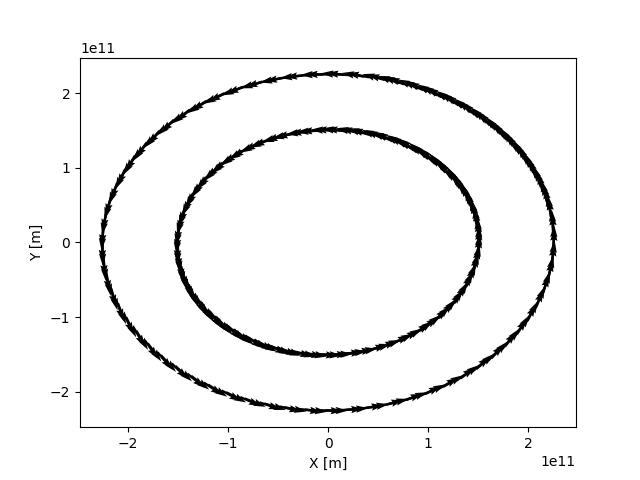

In [270]:
plt.figure()
plt.quiver(x1,y1,vx1,vy1) 
plt.quiver(x2,y2,vx2,vy2) 
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

In [271]:
for i in range(npts):
    for j in range(npts):
        dt = t_arr[i,j] - t_dep[i,j]
        if (dt > min_transfer) and (dt < max_transfer):
            R1 = np.array([x1[i],y1[i],0.0])
            R2 = np.array([x2_rot[i],y2_rot[i],z2_rot[i]])

            # call Lambert solver
            v1_plus, v2_minus, success = AA279lambert_curtis(mu, R1, R2, dm='pro', nrev=0, dtsec = dt)
            v1_minus = np.array([vx1[i],vy1[i],0.0])
            v2_plus  = np.array([vx2_rot[i],vy2_rot[i],vz2_rot[i]])

            # compute burns 
            dv1 = (v1_plus - v1_minus)
            dv2 = (v2_plus - v2_minus)

            # total delta v
            dv_total[i,j] = np.sqrt(dv1.dot(dv1)) + np.sqrt(dv2.dot(dv2))

## Make porkchop plot

/var/folders/lp/nzbfjgh14nv_gzpg4ygpc3_m0000gn/T/ipykernel_34968/2442008999.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm_s, ax=ax, orientation='vertical', pad=0.02)


Text(0, 0.5, 'Arrival time [day]')

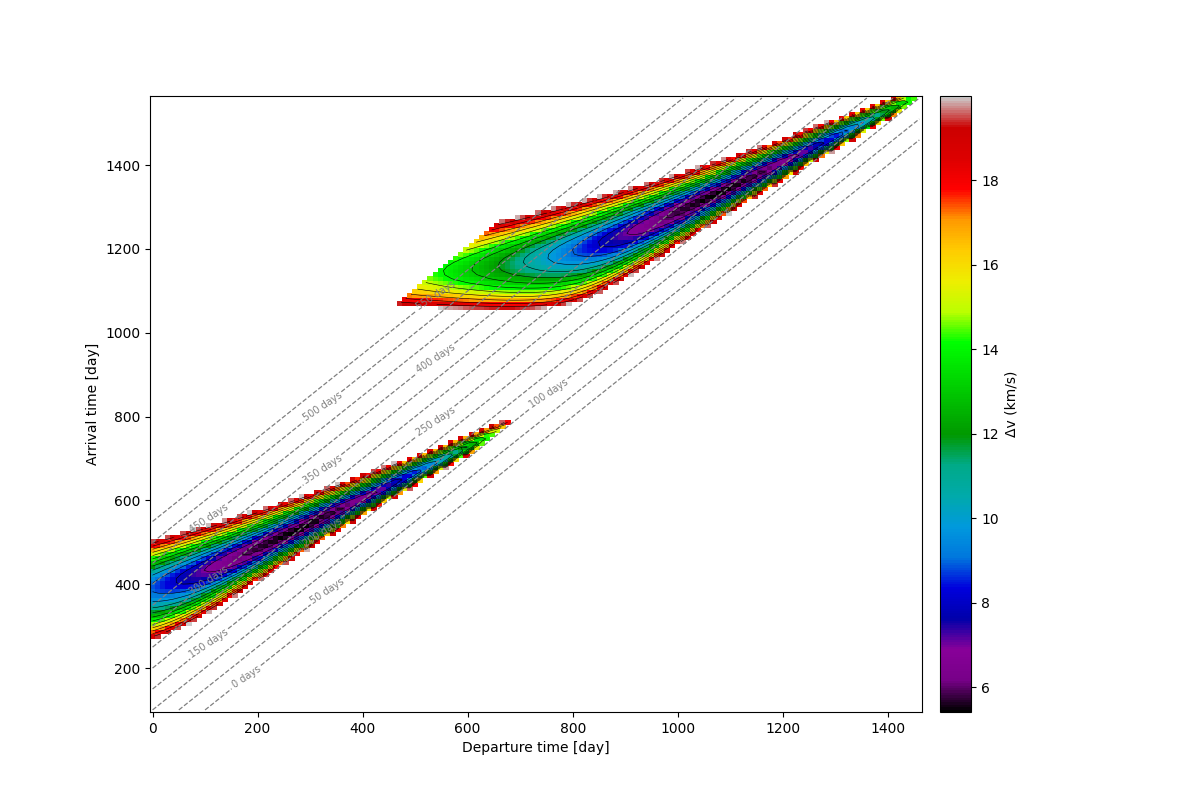

In [272]:
fig, ax = plt.subplots(figsize=(12, 8))

dv_total[dv_total > 20000.0] = np.nan
dv_levels                    = np.arange(0,20,1)
tof_levels                   = np.arange(0, 600, 50)

# DV
pcm_s = plt.pcolor(t_dep / 86400.0,t_arr / 86400.0 , dv_total * 1e-3,cmap='nipy_spectral', shading='auto')
pcc   = plt.contour(t_dep / 86400.0,t_arr / 86400.0 ,dv_total * 1e-3,colors='k',levels = dv_levels,linewidths=0.4)

# TOF
TOF_days_int = np.round(tof / 86400.0).astype(int)
cp_tof       = ax.contour(t_dep / 86400.0,t_arr / 86400.0, TOF_days_int, levels=tof_levels, colors='gray', linestyles='dashed', linewidths=0.9)
ax.clabel(cp_tof, fmt='%d days', fontsize=7, colors='gray')

cbar = fig.colorbar(pcm_s, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Δv (km/s)")

plt.xlabel("Departure time [day]")
plt.ylabel("Arrival time [day]")

#### Find minimum Delta V

In [273]:
np.min(dv_total[~np.isnan(dv_total)]) * 1e-3

5.4104787417001825

In [274]:
dv1 = v1 * (np.sqrt(2 * a2 / (a1 + a2)) - 1) # first Delta V for Hohmann transfer
dv2 = v2 * (1 - np.sqrt(2 * a1 / (a1 + a2))) # second Delta V for Hohmann transfer
dvt_hohmann = dv1 + dv2 # total Delta V for Hohmann transfer
print(dvt_hohmann * 1e-3)

5.4029820169589735


In [275]:
# time of flight for Hohmann transfer
tof_hohmann = pi * np.sqrt( ((0.5 * (a1 + a2)) ** 3) / mu)
print(tof_hohmann / 86400.0)

256.2608257683456
